In [120]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np

from src.features import build_features_final, utils, build_features_optim
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

def z_scores(data):
    z_scores = np.abs((data - data.mean()) / data.std())
    label = z_scores.apply(lambda x: 1 if x.max() > 3 else 0, axis=1)
    return label

In [124]:
scaler = MinMaxScaler()

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency',
                'air_to_motor_ratio']

drop_feature = ['motor_hp', 'type'] 

# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data = build_features_final.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)
train_data['label'] = z_scores(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()
test_data['label'] = z_scores(test_data)


scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data_df = pd.DataFrame(
    scaled_train_data, columns=train_data.columns)
scaled_test_data_df = pd.DataFrame(
    scaled_test_data, columns=train_data.columns)

n_features = scaled_train_data_df.shape[1]
print(n_features)

scaled_train_data = scaled_train_data_df.values
scaled_test_data = scaled_test_data_df.values


21


In [127]:
all_data = pd.concat([scaled_train_data_df, scaled_test_data_df])

In [131]:
x_test = scaled_test_data_df.drop('label', axis=1)

In [129]:
x_train = scaled_train_data_df.drop('label', axis=1)
y_train = scaled_train_data_df['label']

In [134]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
submission = prediction_to_csv(y_pred)

0    7246
1     143
Name: label, dtype: int64


In [90]:
from sklearn.covariance import EllipticEnvelope
import numpy as np

envelope = EllipticEnvelope(support_fraction = 0.966, contamination = 0.04, random_state = 1103)
envelope.fit(all_data)
pred = np.where(envelope.predict(scaled_test_data_df) == -1, 1, 0)




0    7044
1     345
Name: label, dtype: int64


In [91]:
scaled_test_data_df['prediction'] = pred

In [107]:
filtered_df = scaled_test_data_df.apply(
    lambda x: x[np.abs((x - x.mean()) / x.std()) < 3])

# NA 값을 가진 행 제거
print("Drop Data \n", filtered_df.isna().sum())

Drop Data 
 air_inflow               136
air_end_temp               0
out_pressure               7
motor_current             94
motor_rpm                  0
motor_temp                 0
motor_vibe                16
air_flow_pressure        136
current_by_airflow        26
temp_diff                 36
current_by_vibration     185
airflow_per_rotation       0
efficiency                12
volumetric_efficiency      0
fan_laws_6                23
performance_index         12
air_to_motor_ratio         0
air_to_power_ratio        12
mechanical_efficiency      6
out_pressure_squared       7
dtype: int64


In [93]:
a = filtered_df[filtered_df.isna().any(axis=1)]

In [94]:
b = a[a['prediction']==0]

In [29]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination = 0.04, random_state = 1103, n_estimators=500, max_features=n_features)
iso.fit(all_data)
pred = np.where(envelope.predict(scaled_test_data_df) == -1, 1, 0)

iso_submission = prediction_to_csv(pred)


0    7042
1     347
Name: label, dtype: int64


In [30]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 0 labels with value 1


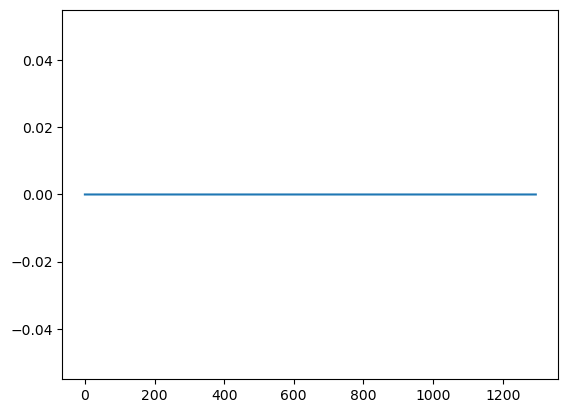

Chunk 1: 0 labels with value 1


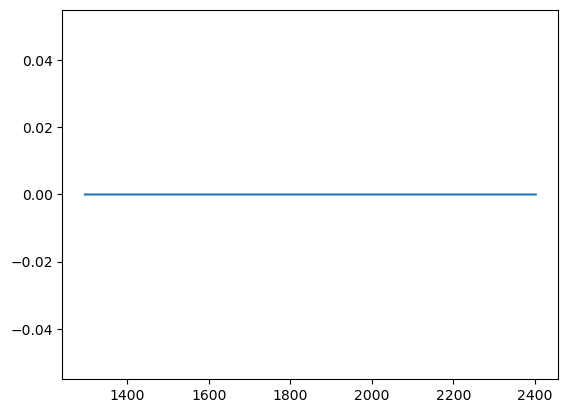

Chunk 2: 0 labels with value 1


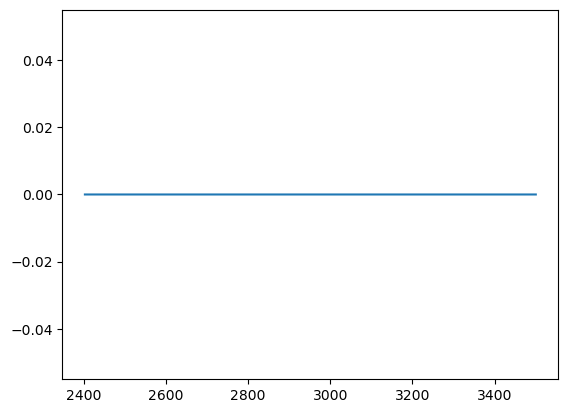

Chunk 3: 143 labels with value 1


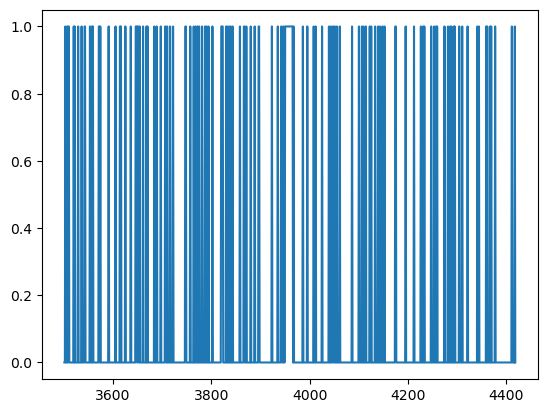

Chunk 4: 0 labels with value 1


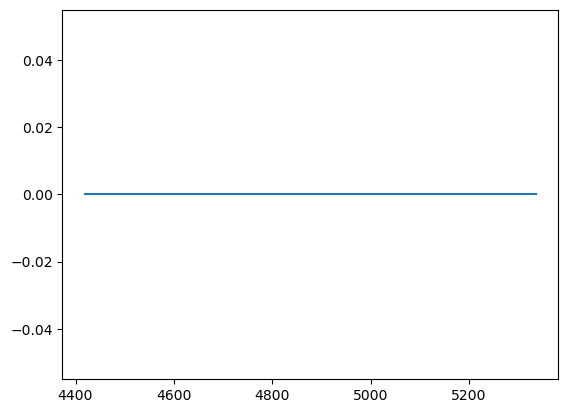

Chunk 5: 0 labels with value 1


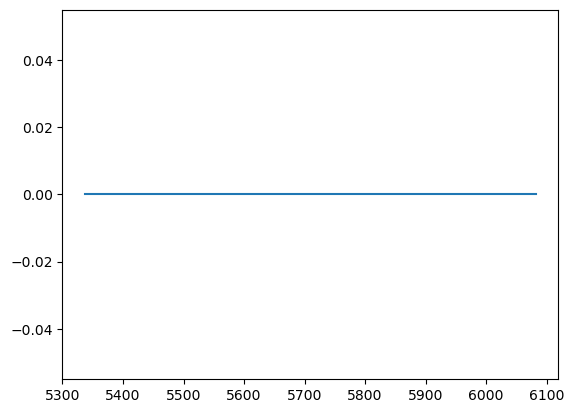

Chunk 6: 0 labels with value 1


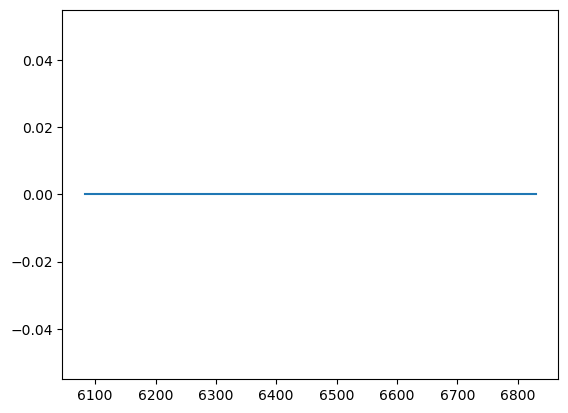

Chunk 7: 0 labels with value 1


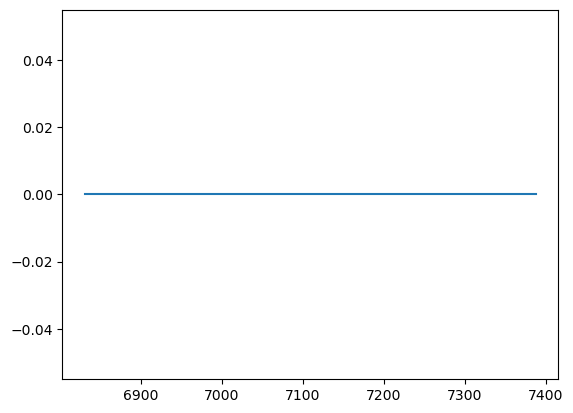

In [135]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(test_data))]
plot_label_counts(submission, ranges)